# ANNDL first homework (Data Processing)

## Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ANNDL_Homework_1

Mounted at /gdrive
/gdrive/My Drive/ANNDL_Homework_1


## Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [ ]:
# Import other libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim
import hashlib

## Load and process the dataset

#### Load data

In [ ]:
# Unzip the 'public_data.zip' file
if False:
    !unzip public_data.zip

In [ ]:
# Load 'public_data.npz' file
data = np.load('public_data.npz', allow_pickle=True)

#### Load images

In [ ]:
def load_images(data):

    images = []

    # Iterate through files in the specified folder
    for img in data:

        # Normalize image pixel values to a float range [0, 1]
        img = (img / 255).astype(np.float32)

        if img is not None:
            images.append(img)

    return np.array(images)

X = load_images(data['data'])

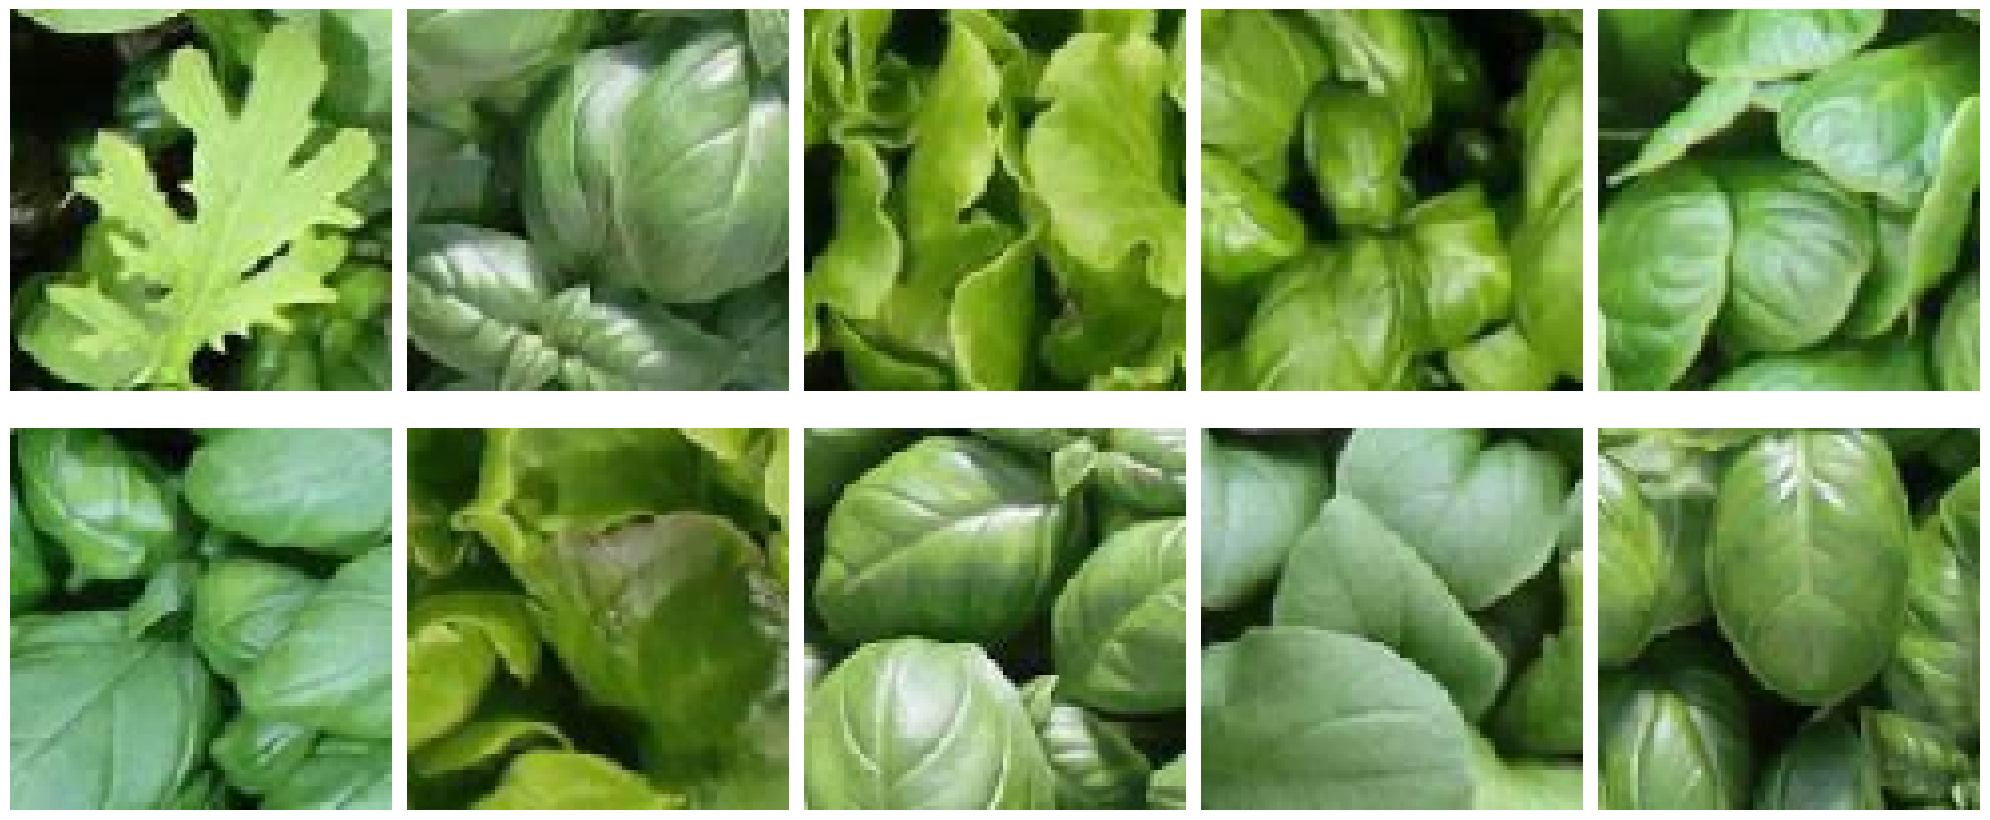

In [ ]:
# Number of images to display
num_img = 10

# Create subplots for displaying items
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(X[i])
    ax.axis('off')
plt.tight_layout()
plt.show()

#### Load labels

In [ ]:
y = np.where(data['labels'] == 'healthy', 0, 1)

In [ ]:
# Count the occurrences of each label
unique_labels, label_counts = np.unique(y, return_counts=True)
print('Target labels:', unique_labels)
for u in unique_labels:
    print(f'Class {unique_labels[u]} has {label_counts[u]} samples')

Target labels: [0 1]
Class 0 has 3199 samples
Class 1 has 2001 samples


In [ ]:
# Find the indices for label 1 and label 0
healty_indices = np.where(y == unique_labels[0])[0][:5]
unhealty_indices = np.where(y == unique_labels[1])[0][:5]

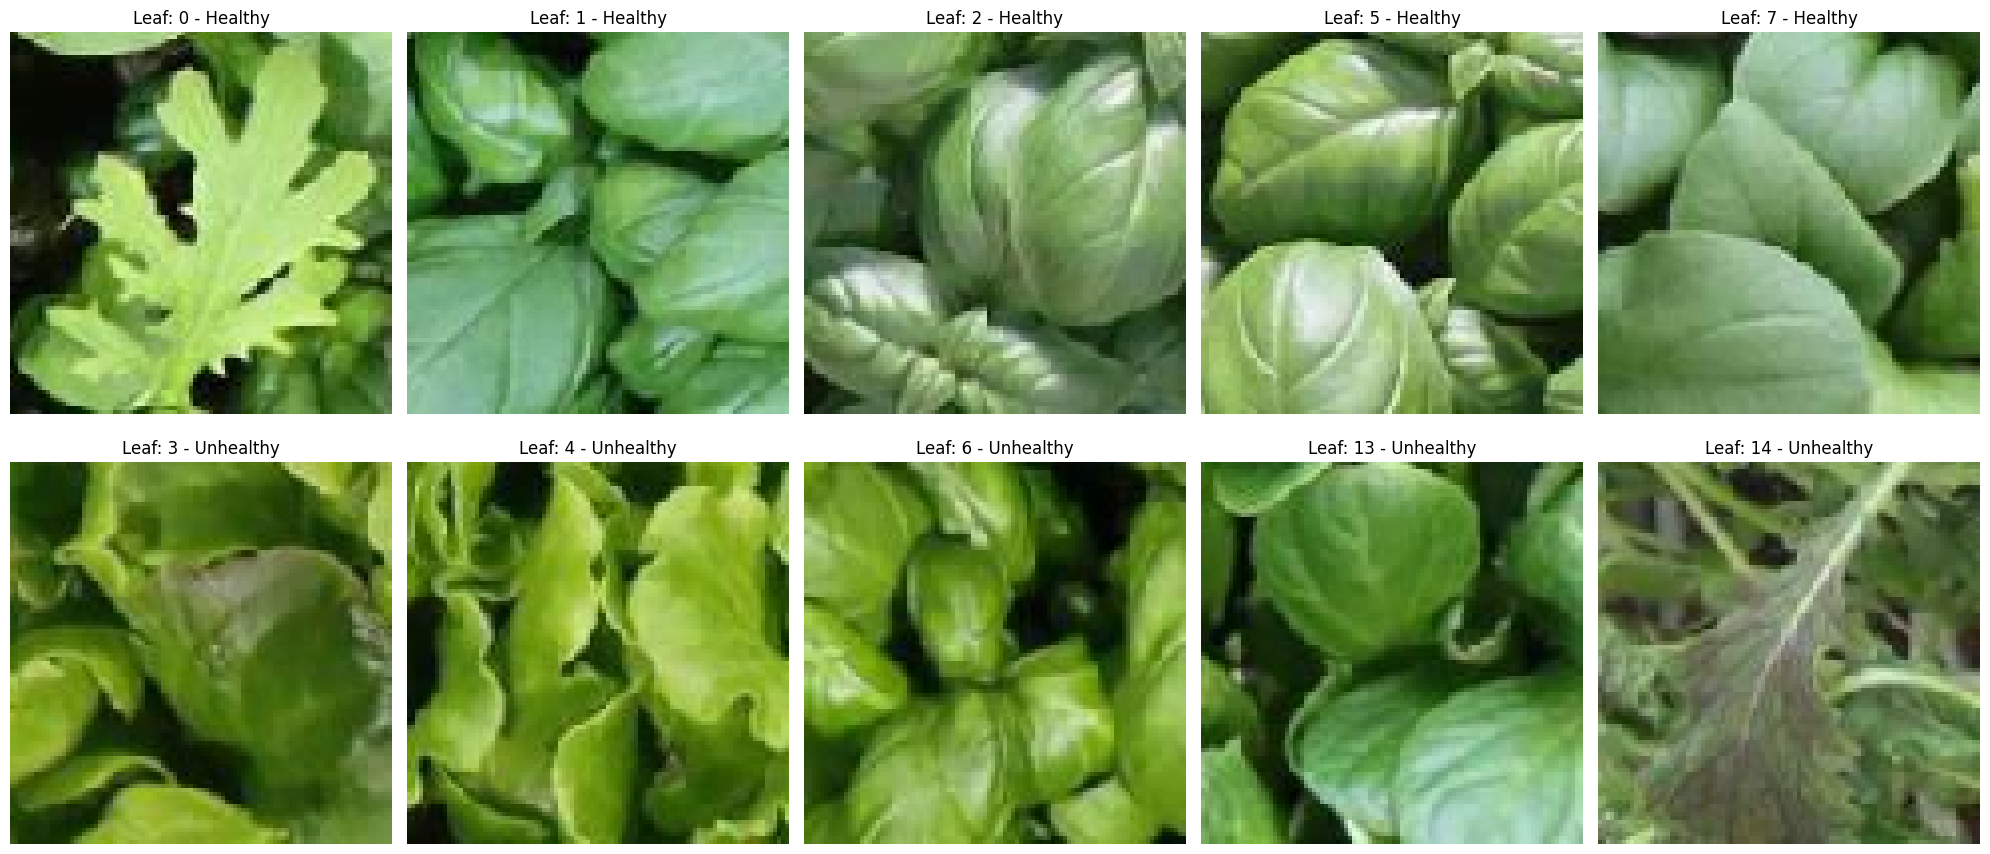

In [ ]:
# Create subplots for displaying items
fig, axes = plt.subplots(2, 5, figsize=(20, 9))

# Plot images from healty_indices
for i, idx in enumerate(healty_indices):
    ax = axes[0, i]
    ax.imshow(np.clip(X[idx], 0, 255))  # Display clipped item images
    ax.axis('off')
    ax.set_title(f"Leaf: {idx} - Healthy")  # Set title for the first row

# Plot images from unhealty_indices
for i, idx in enumerate(unhealty_indices):
    ax = axes[1, i]
    ax.imshow(np.clip(X[idx], 0, 255))  # Display clipped item images
    ax.axis('off')
    ax.set_title(f"Leaf: {idx} - Unhealthy")  # Set title for the second row

plt.tight_layout()
plt.show()

#### Analyze images

##### First inspection

We are inspecting the data in order to find possible 'incoherent' images w.r.t. our case study.

To do this we well select an image by our choice as reference and measure the dissimilarities of all other images with respect to it.
The most dissimilar images are those that may have not any utility w.r.t. our classification problem.

In [ ]:
# Measure dissimilarity between an image and the others using MSE
def measure_dissimilarity(image, other_images):
    dissimilarities = []
    # Calculate the dissimilarity between the image and each other image
    for other_image in other_images:
        # Calculate the MSE between the images
        #dissimilarity = np.mean((image - other_image) ** 2)
        dissimilarity = 1 - ssim(image, other_image, multichannel=True)
        dissimilarities.append(dissimilarity)
    return dissimilarities

In [ ]:
# Find the most dissimilar images in the whole dataset w.r.t the reference image
def find_most_dissimilar_images(X, num_images, image):
    num_total_images = X.shape[0]
    # Select an image as the reference
    reference_image = image
    # Measure the dissimilarity of the reference image with all other images
    dissimilarities = measure_dissimilarity(reference_image, X)
    # Get the indices of the most dissimilar images
    most_dissimilar_indices = np.argsort(dissimilarities)[-num_images:][::-1]
    return most_dissimilar_indices

Let's have a look to the results:

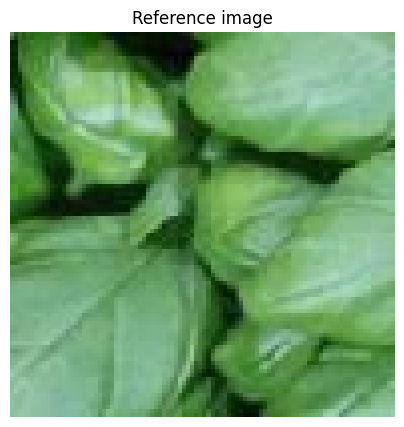

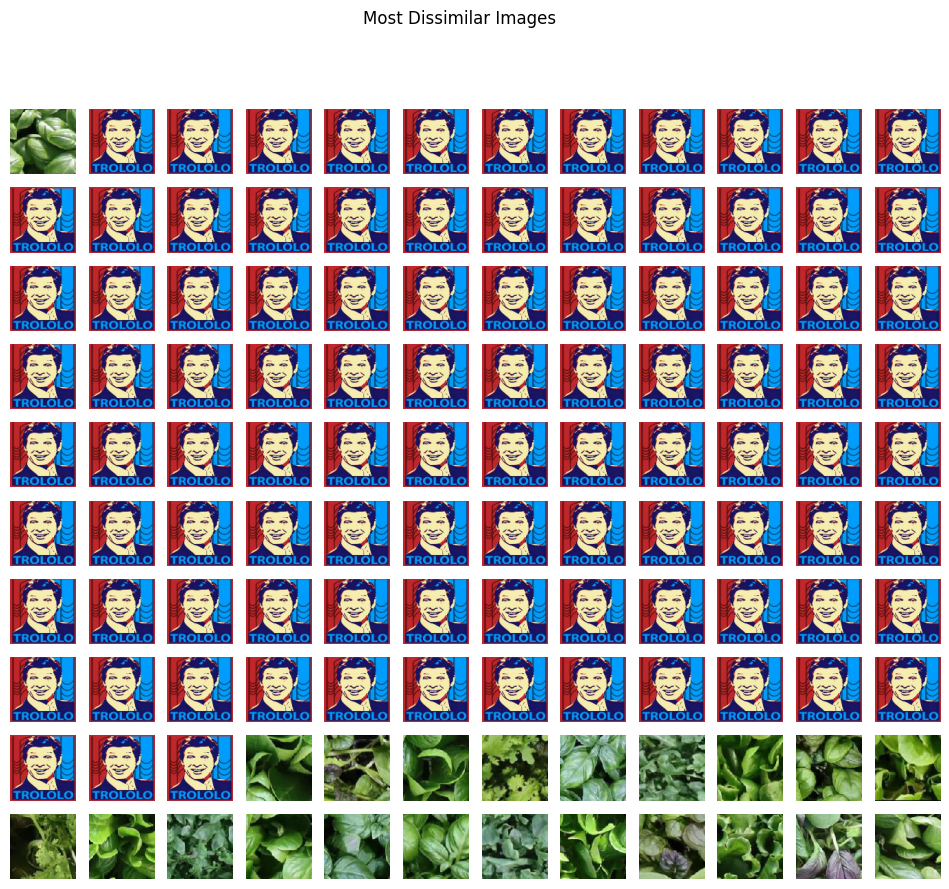

In [ ]:
most_dissimilar_indices = find_most_dissimilar_images(X, 120, X[1])
most_dissimilar_images = X[most_dissimilar_indices]

fig, axes = plt.subplots(figsize=(5, 5))
axes.imshow(X[1])
axes.axis('off')
axes.set_title('Reference image')  # Add a title to the first image

# Plot the most dissimilar images in a 10 by 12 grid
fig, axes = plt.subplots(10, 12, figsize=(12, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(most_dissimilar_images[i])
    ax.axis('off')

fig.suptitle('Most Dissimilar Images')  # Add a title to the second plot

plt.show()

By visually inspecting the output it's easy to identify many identical "incoherent" images that we can consider as outliers that need to be removed from our data.

##### Duplicate inspection

Looking for possible duplicate images in the dataset by exploiting hash values.

In [ ]:
# Calculate the hash values for each image
hashes = np.empty(len(X), dtype=object)
for i, image in enumerate(X):
    image_bytes = image.tobytes()
    image_hash = hashlib.md5(image_bytes).hexdigest()
    hashes[i] = image_hash

# Find duplicate images based on hash values
duplicate_indices = np.empty(len(X), dtype=np.int32)
seen_hashes = set()
duplicate_count = 0
for i, image_hash in enumerate(hashes):
    if image_hash in seen_hashes:
        duplicate_indices[duplicate_count] = i
        duplicate_count += 1
    else:
        seen_hashes.add(image_hash)

# Trim duplicate_indices array to actual size
duplicate_indices = duplicate_indices[:duplicate_count]

print("Duplicate image indices:", duplicate_indices)
print("Number of duplicates: ", len(duplicate_indices))

Duplicate image indices: [  95  137  138  159  171  207  243  301  334  412  434  462  486  506
  523  529  538  571  578  599  622  658  692  701  722  723  725  753
  779  783  808  827  840  880  885  898  901  961  971  974  988  989
 1013 1028 1044 1064 1065 1101 1142 1149 1172 1190 1191 1248 1265 1268
 1280 1333 1340 1384 1443 1466 1470 1483 1528 1541 1554 1594 1609 1630
 1651 1690 1697 1712 1715 1752 1757 1759 1761 1783 1803 1806 1828 1835
 1866 1870 1884 1903 1918 1938 1939 1958 1967 1977 1981 1988 2022 2066
 2081 2090 2147 2150 2191 2192 2194 2196 2198 2210 2261 2264 2272 2284
 2291 2303 2311 2328 2348 2380 2387 2397 2413 2426 2435 2451 2453 2487
 2496 2515 2522 2528 2564 2574 2576 2581 2593 2596 2612 2627 2663 2665
 2667 2675 2676 2702 2727 2733 2734 2736 2755 2779 2791 2796 2800 2817
 2830 2831 2839 2852 2864 2866 2878 2889 2898 2912 2913 2928 2929 2937
 2963 2964 3033 3049 3050 3055 3060 3062 3086 3093 3105 3108 3144 3151
 3154 3155 3240 3244 3264 3286 3376 3385 3390 3402 3

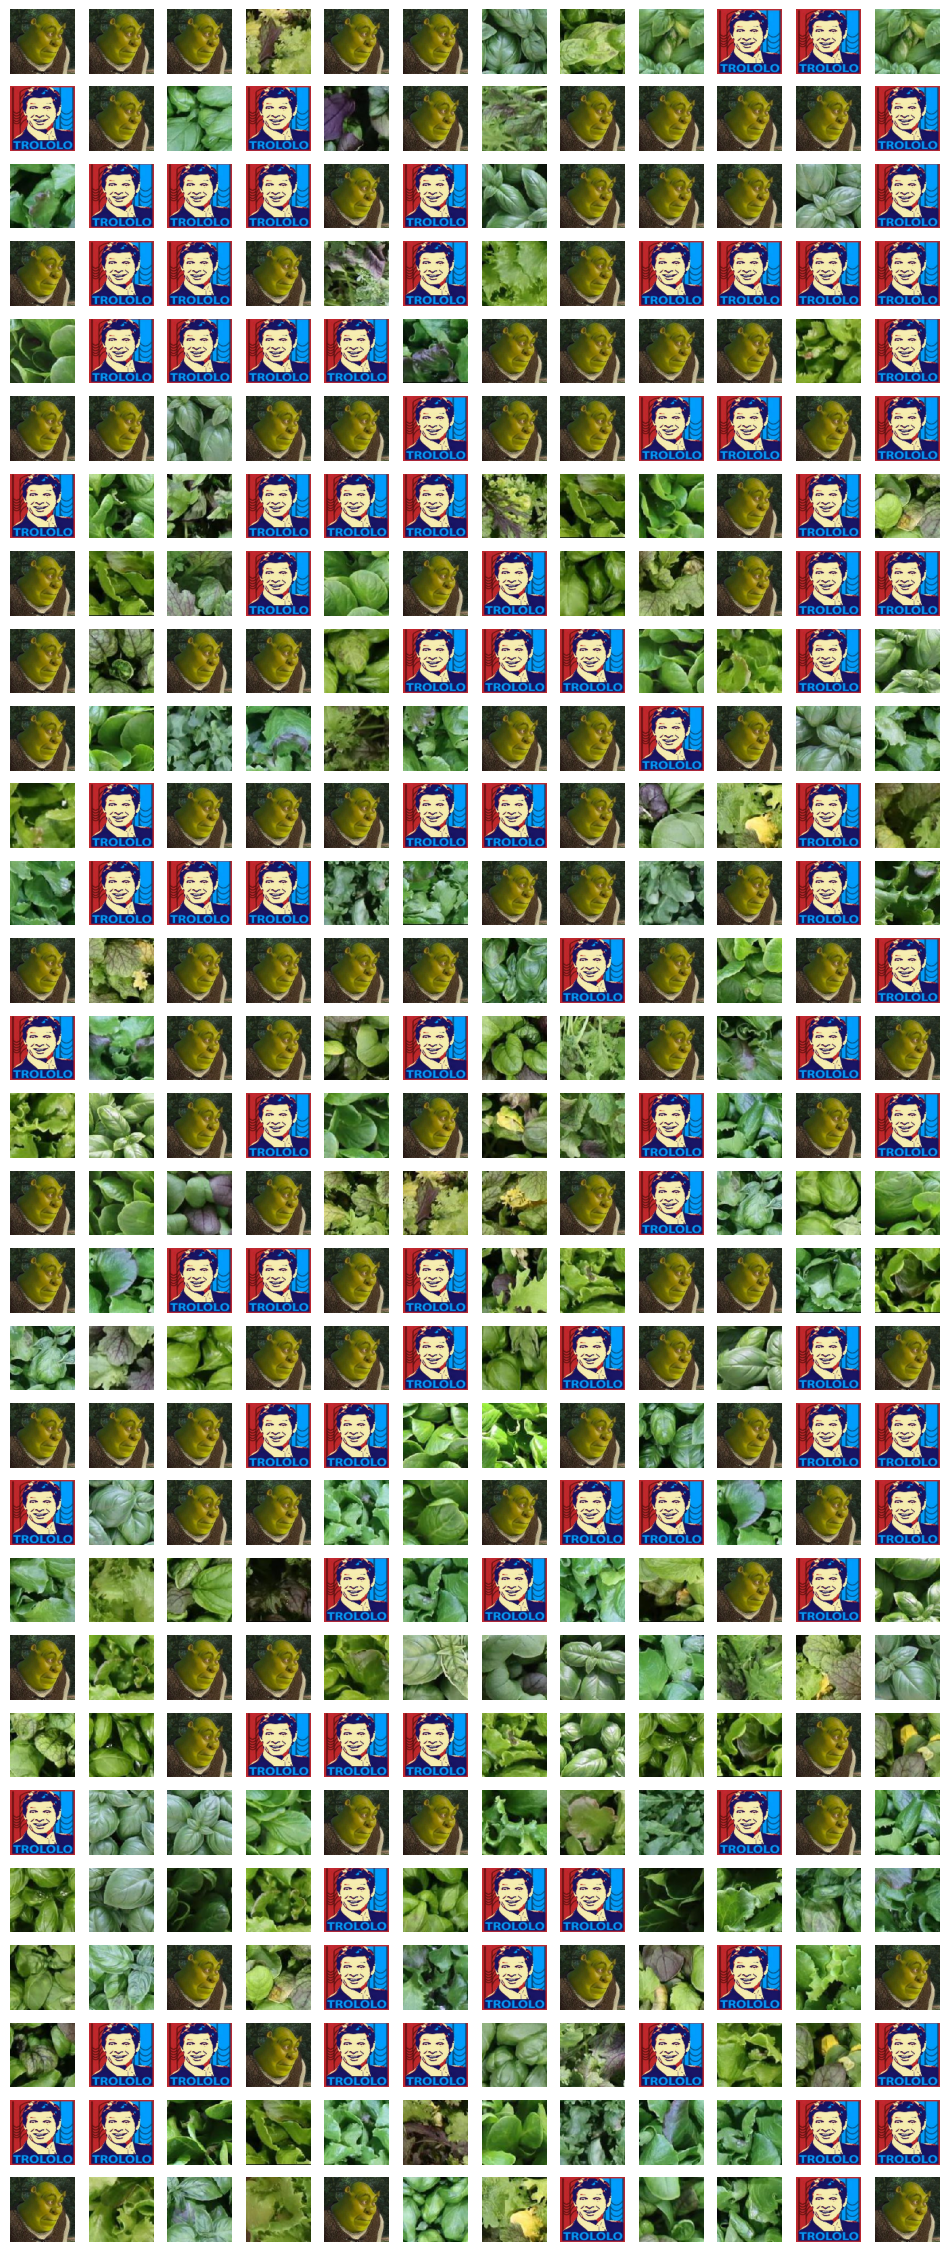

In [ ]:
# Plot duplicate images
fig, axes = plt.subplots(29, 12, figsize=(12, 29))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[duplicate_indices][i])
    ax.axis('off')

plt.show()

We found that in our data there are many 'incoherent' duplicate images of **'Trololo'**, **'Sherk'** and others more coherent but still duplicated.

We need get rid of these images otherwise we won't be able to perfom a good training of our model for a few reasons:

- Biases and Overfitting: Duplicate images can introduce biases into the training data, leading to overfitting. When the model encounters the same image multiple times, it may learn to rely heavily on specific features present in those images, rather than generalizing patterns from a diverse set of images. This can result in poor performance on new, unseen images.

- Inflated Performance Metrics: If duplicate images are present in both the training and test sets, the model's performance metrics may be artificially inflated. Since the model has already seen similar images during training, it may perform well on those duplicates in the test set, giving a false sense of accuracy. However, the model's ability to generalize to new, distinct images may be compromised.

- Wasted Computational Resources: Including duplicate images in the training data can waste computational resources. The model will spend time processing redundant information, which could have been better utilized for training on a larger variety of images.

In [ ]:
X_no_duplicates = X[~np.isin(np.arange(len(X)), duplicate_indices)]
y_no_duplicates = y[~np.isin(np.arange(len(y)), duplicate_indices)]

print("Images set dimension:", X_no_duplicates.shape)
print("Labels set dimension:",y_no_duplicates.shape[0])

Images set dimension: (4852, 96, 96, 3)
Labels set dimension: 4852


Subsequently we need to look for the 2 reference images of Trololo and Shrek that our hashing algorithm used to find the duplicates.
This is done by finding identical images of those two images in the new dataset.

In [ ]:
# Find the most similar images in the whole dataset w.r.t the reference image
def find_identical_images(X, num_images,reference):
    num_total_images = X.shape[0]
    # Select an image as the reference
    reference_image = reference
    # Measure the dissimilarity of the reference image with all other images
    dissimilarities = measure_dissimilarity(reference_image, X)
    # Get the indices of the least dissimilar images
    less_dissimilar_indices = np.argsort(dissimilarities)[:num_images]
    return less_dissimilar_indices

Reference image of Trololo:


(-0.5, 95.5, 95.5, -0.5)

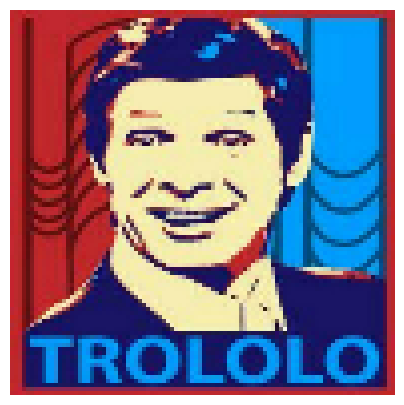

In [ ]:
print("Reference image of Trololo:")
fig, axes = plt.subplots(figsize=(5, 5))
axes.imshow(X[412])
axes.axis('off')

Reference image of Shrek:


(-0.5, 95.5, 95.5, -0.5)

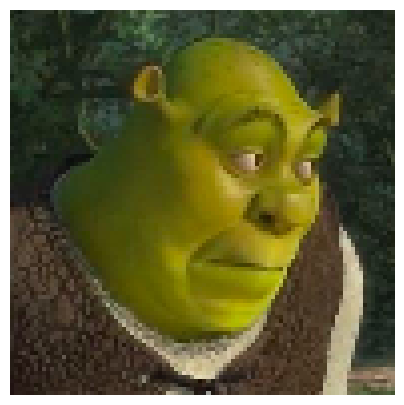

In [ ]:
print("Reference image of Shrek:")
fig, axes = plt.subplots(figsize=(5, 5))
axes.imshow(X[95])
axes.axis('off')

In [ ]:
shrek_index = find_identical_images(X_no_duplicates,1, X[95])
trololo_indices = find_identical_images(X_no_duplicates, 1, X[412])

S_T_to_remove = np.concatenate((shrek_index,trololo_indices))
print(S_T_to_remove)

[ 58 329]


In [ ]:
X_filtered = X_no_duplicates[~np.isin(np.arange(len(X_no_duplicates)), S_T_to_remove)]
y_filtered = y_no_duplicates[~np.isin(np.arange(len(y_no_duplicates)), S_T_to_remove)]

print("Images set dimension:", X_filtered.shape)
print("Labels set dimension:",y_filtered.shape[0])

Images set dimension: (4850, 96, 96, 3)
Labels set dimension: 4850


## Split in train, validation and test

In [ ]:
X_filtered.shape[0]

4850

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=seed)

# Further split the training set into training and validation sets
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.6, random_state=seed)

# Print the shapes of the resulting sets
# Print shapes of the datasets
print(f"X_train shape: {X_train.shape} - y_train shape: {y_train.shape}")
print(f"X_val shape:   {X_val.shape}  - y_val shape:   {y_val.shape}")
print(f"X_test shape:  {X_test.shape}  - y_test shape:  {y_test.shape}")

X_train shape: (3880, 96, 96, 3) - y_train shape: (3880,)
X_val shape:   (582, 96, 96, 3)  - y_val shape:   (582,)
X_test shape:  (388, 96, 96, 3)  - y_test shape:  (388,)


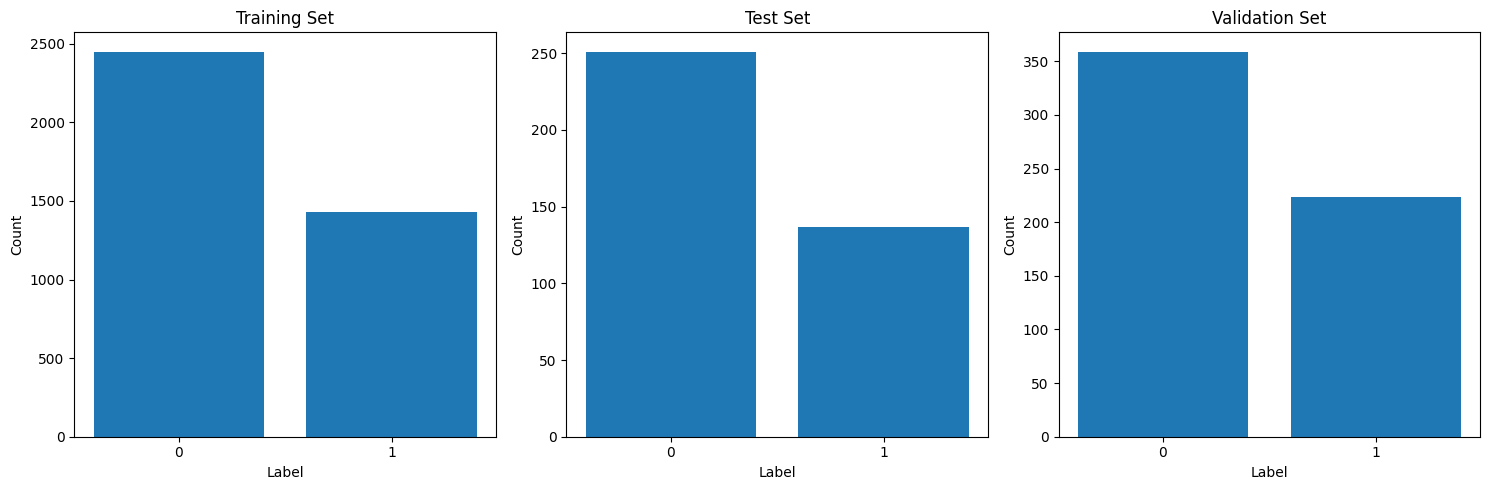

In [ ]:
# Convert y_train, y_test, and y_val to pandas Series
y_train_series = pd.Series(y_train)
y_test_series = pd.Series(y_test)
y_val_series = pd.Series(y_val)

# Calculate the count of each label in the training set, test set, and validation set
label_counts_train = y_train_series.value_counts()
label_counts_test = y_test_series.value_counts()
label_counts_val = y_val_series.value_counts()

# Create a figure with three subplots in one row
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the distribution of labels in each subplot
axs[0].bar(label_counts_train.index, label_counts_train.values)
axs[0].set_xlabel('Label')
axs[0].set_ylabel('Count')
axs[0].set_title('Training Set')
axs[0].set_xticks([0, 1])

axs[1].bar(label_counts_test.index, label_counts_test.values)
axs[1].set_xlabel('Label')
axs[1].set_ylabel('Count')
axs[1].set_title('Test Set')
axs[1].set_xticks([0, 1])

axs[2].bar(label_counts_val.index, label_counts_val.values)
axs[2].set_xlabel('Label')
axs[2].set_ylabel('Count')
axs[2].set_title('Validation Set')
axs[2].set_xticks([0, 1])

# Adjust the spacing between subplots
plt.tight_layout()
plt.show()

### Save data for fine tuning

In [ ]:
# Convert labels to one-hot encoding format
y_train_orig = tfk.utils.to_categorical(y_train,2)
y_val_orig = tfk.utils.to_categorical(y_val,2)
y_test_orig = tfk.utils.to_categorical(y_test,2)

In [ ]:
# Save the arrays into a .npz file
np.savez('Original_Data_Splitted.npz', X_train=X_train, y_train=y_train_orig, X_val=X_val, y_val=y_val_orig, X_test=X_test, y_test=y_test_orig)

In [ ]:
print(f"X_train shape: {X_train.shape} - y_train shape: {y_train_orig.shape}")
print(f"X_val shape:   {X_val.shape}  - y_val shape:   {y_val_orig.shape}")
print(f"X_test shape:  {X_test.shape}  - y_test shape:  {y_test_orig.shape}")

X_train shape: (3880, 96, 96, 3) - y_train shape: (3880, 2)
X_val shape:   (582, 96, 96, 3)  - y_val shape:   (582, 2)
X_test shape:  (388, 96, 96, 3)  - y_test shape:  (388, 2)


## Image Augmentation

We are applying some techniques of image augmentation to the training data.

In [ ]:
training_size = X_train.shape[0]
print(training_size)

3880


In [ ]:
# Find the indices for label 1 and label 0
healty_indices = np.where(y_train == unique_labels[0])[0]
unhealty_indices = np.where(y_train == unique_labels[1])[0]
print("Number of healty images:",healty_indices.shape[0])
print("Number of unhealty images:",unhealty_indices.shape[0])

Number of healty images: 2450
Number of unhealty images: 1430


### Flip + Balance

I have to understand how much the training set is unbalanced.

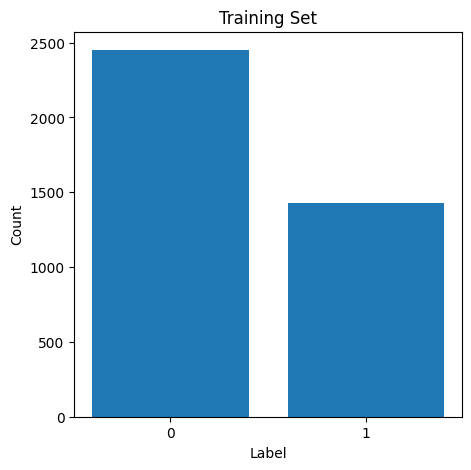

In [ ]:
# Convert y_train to pandas Series
y_train_series = pd.Series(y_train)

# Calculate the count of each label in the training set
label_counts_train = y_train_series.value_counts()
fig, ax = plt.subplots(1, figsize=(5, 5))

# Plot the distribution of labels
ax.bar(label_counts_train.index, label_counts_train.values)
ax.set_xlabel('Label')
ax.set_ylabel('Count')
ax.set_title('Training Set')
ax.set_xticks([0, 1])

plt.show()

Now I have to understand how many images I have to flip to balance the dataset.

In [ ]:
diff_images = abs(label_counts_train.values[0]-label_counts_train.values[1])

print("Number of images that make the training set unbalanced:",diff_images)

Number of images that make the training set unbalanced: 1020


This is the number of images that I have to add to the class with less images. In this way I will balance the dataset.

By visually inspect the graph I see that class 1 (unhealthy plants) is the one with less images, then I will add to this class some images.

In [ ]:
num_images_to_flip  = diff_images
class_to_flip = 1

#define the function that flips images belonging only to the specified class
def flip_image_in_class(X_train, num_image_to_flip, class_to_flip, axis):
  #create the array of flipped images
  flipped_images=[]
  flipped_images_labels = []
  num_flipped_image = 0
  for i in range(X_train.shape[0]):
    if(y_train[i] == class_to_flip):
      flipped_image = np.flip(X_train[i], axis)
      flipped_images.append(flipped_image)
      flipped_images_labels.append(y_train[i])
      num_flipped_image += 1
    if(num_flipped_image == num_image_to_flip):
      break

  return np.array(flipped_images),np.array(flipped_images_labels)

Now flip images.

In [ ]:
flipped_images_vertical, flipped_images_vertical_labels = flip_image_in_class(X_train, int(num_images_to_flip) ,class_to_flip, 0)

print("Vertically flipped images:",flipped_images_vertical.shape[0])

Vertically flipped images: 1020


In [ ]:
flipped_images = np.concatenate((X_train, flipped_images_vertical))
flipped_labels = np.concatenate((y_train,flipped_images_vertical_labels))
print("The final dimension of the training images is:", flipped_images.shape)
print("The final dimension of the training labels is:", flipped_labels.shape)

The final dimension of the training images is: (4900, 96, 96, 3)
The final dimension of the training labels is: (4900,)


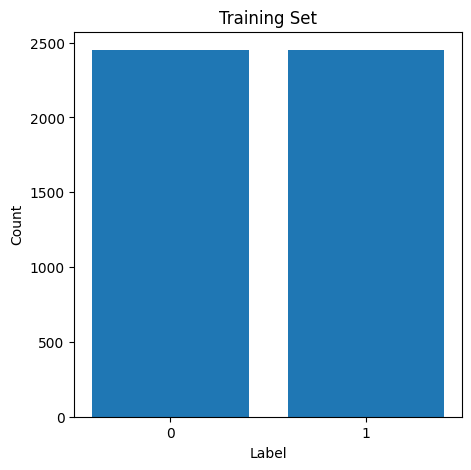

In [ ]:
# Convert y_train to pandas Series
y_train_series = pd.Series(flipped_labels)

# Calculate the count of each label in the training set
label_counts_train = y_train_series.value_counts()
fig, ax = plt.subplots(1, figsize=(5, 5))

# Plot the distribution of labels
ax.bar(label_counts_train.index, label_counts_train.values)
ax.set_xlabel('Label')
ax.set_ylabel('Count')
ax.set_title('Training Set')
ax.set_xticks([0, 1])

plt.show()

### AugMix

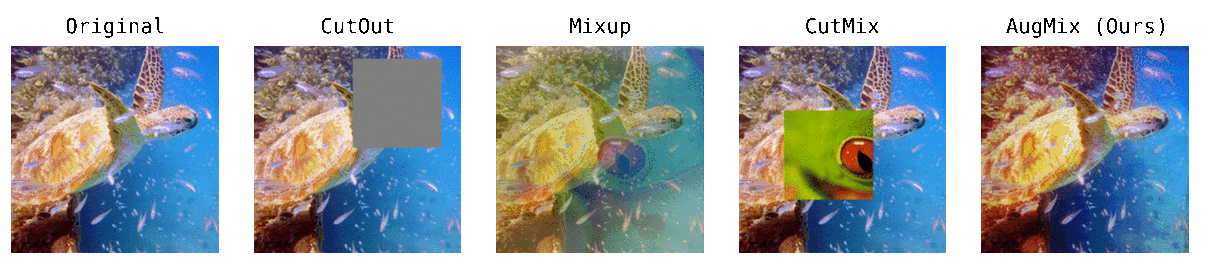

How  it works:
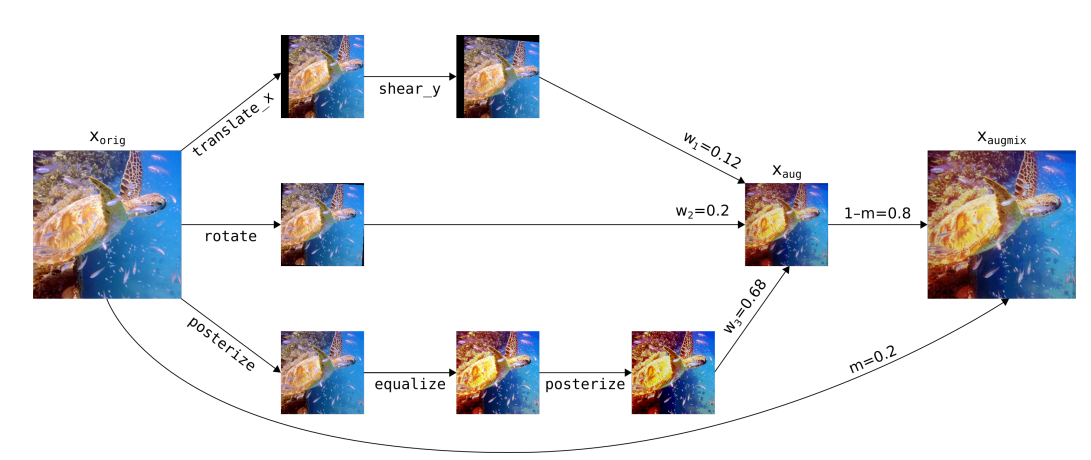

#### Performances on CIFAR-10

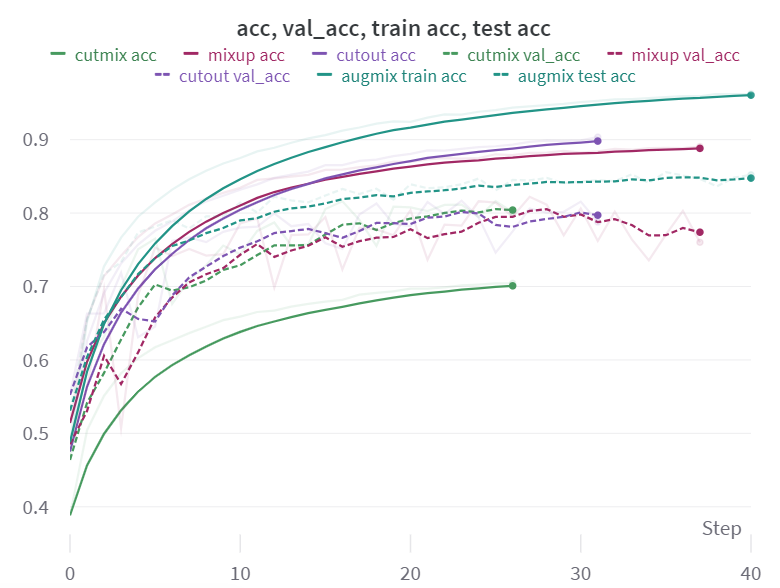

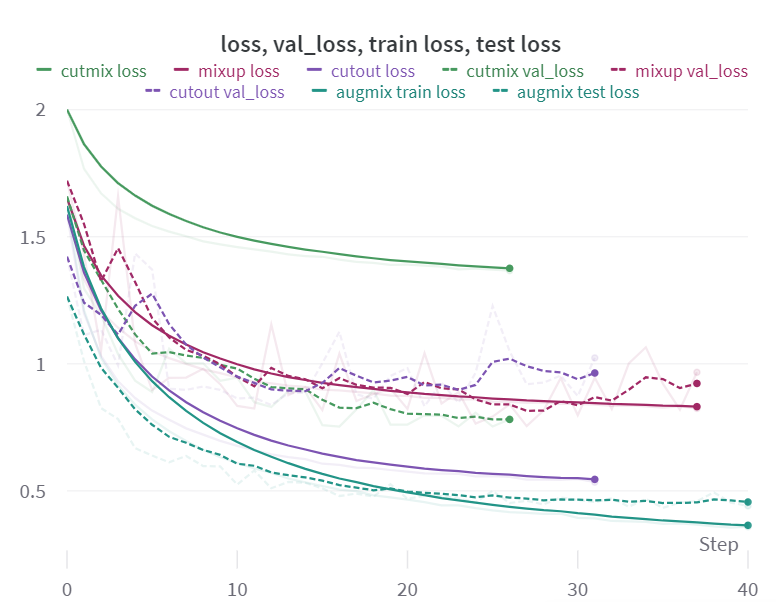

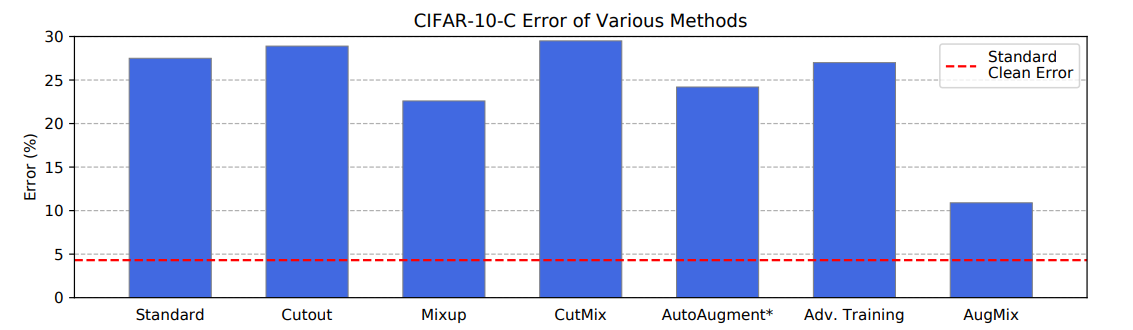

#### Apply AugMix

* AugMix documentation: https://github.com/google-research/augmix
* AugMix paper: https://arxiv.org/pdf/1912.02781.pdf
* Keras documentation: https://keras.io/api/keras_cv/layers/augmentation/aug_mix/

In [ ]:
%%capture
!pip install keras-cv

In [ ]:
from keras_cv.layers import AugMix
augmix = AugMix([0, 1], num_chains=3, chain_depth=random.randint(1,4), seed=seed)

Using TensorFlow backend


#### Data Balancing

In [ ]:
# Find the indices for label 1 and label 0
healty_indices = np.where(flipped_labels == unique_labels[0])[0]
unhealty_indices = np.where(flipped_labels == unique_labels[1])[0]
print("Number of healty images:",healty_indices.shape[0])
print("Number of unhealty images:",unhealty_indices.shape[0])

Number of healty images: 2450
Number of unhealty images: 2450


#### Augmented Images

##### Augmented Healty Images

In [ ]:
augmented_healty_images = augmix(flipped_images[healty_indices])

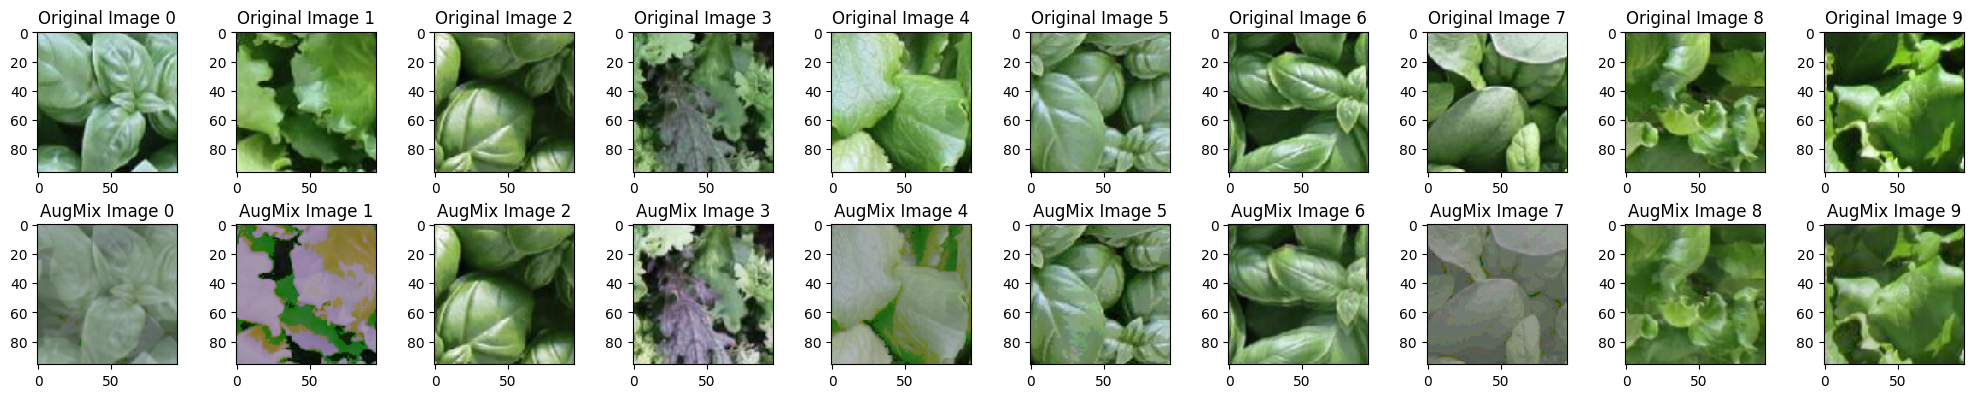

In [ ]:
num_img = 10
fig, axes = plt.subplots(2, num_img, figsize=(20,4))

j = 0
for i in healty_indices:
    if j>=10:
        break
    ax = axes[0,j%num_img]
    ax.imshow(X_train[i])
    ax.set_title(f'Original Image {i}')  # Add title to the top row of subplots

    ax = axes[1,j%num_img]
    ax.imshow(augmented_healty_images[j])
    ax.set_title(f'AugMix Image {j}')  # Add title to the bottom row of subplots

    j += 1

plt.tight_layout()
plt.show()

##### Augmented Unhealty Images

In [ ]:
augmented_unhealty_images = augmix(flipped_images[unhealty_indices])

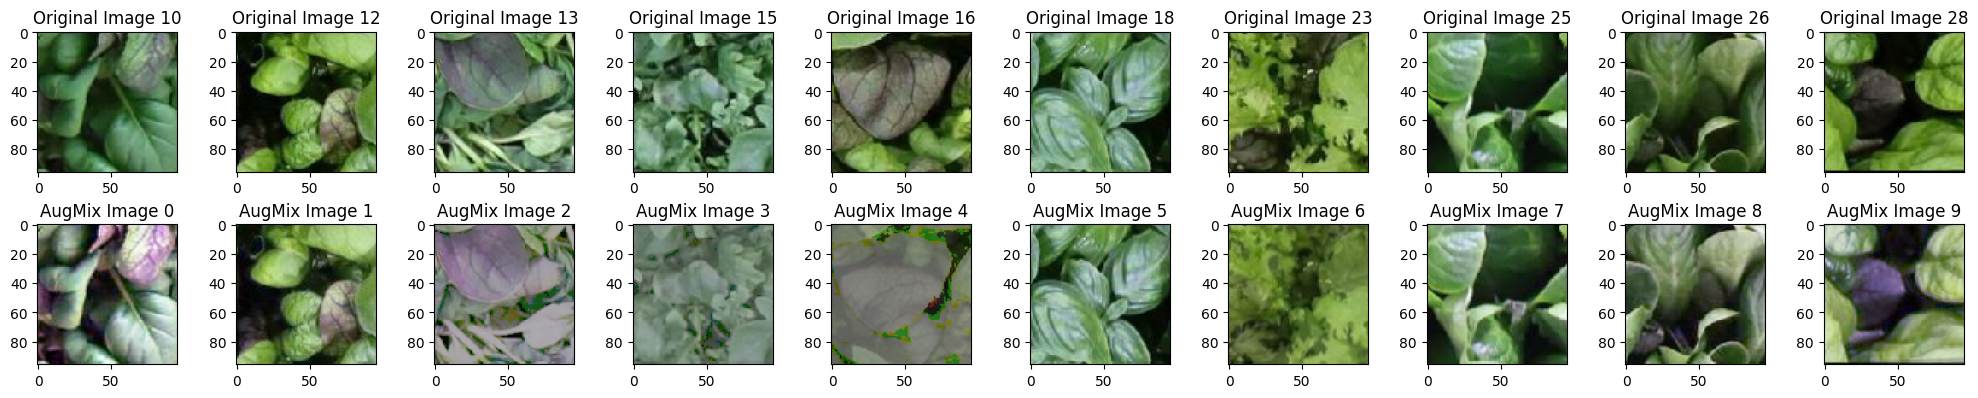

In [ ]:
num_img = 10
fig, axes = plt.subplots(2, num_img, figsize=(20,4))

j = 0
for i in unhealty_indices:
    if j>=10:
        break
    ax = axes[0,j%num_img]
    ax.imshow(X_train[i])
    ax.set_title(f'Original Image {i}')  # Add title to the top row of subplots

    ax = axes[1,j%num_img]
    ax.imshow(augmented_unhealty_images[j])
    ax.set_title(f'AugMix Image {j}')  # Add title to the bottom row of subplots

    j += 1

plt.tight_layout()
plt.show()

#### Add Augmented Data to Training

In [ ]:
augmix_images = np.concatenate((augmented_healty_images, augmented_unhealty_images))
augmix_labels = np.concatenate((flipped_labels[healty_indices],flipped_labels[unhealty_indices]))
print("The final dimension of the training images is:", augmix_images.shape)
print("The final dimension of the training labels is:", augmix_labels.shape)

The final dimension of the training images is: (4900, 96, 96, 3)
The final dimension of the training labels is: (4900,)


In [ ]:
training_size = augmix_images.shape[0]

### Flip

Now apply the flip of the last images in the training set in order to do further data augmentation.

In [ ]:
tune_flip_percentage = 100
flip_param = int((tune_flip_percentage / 100) * augmix_images.shape[0])

Define the function to flip the images in the training set starting from the end.

In [ ]:
def flip_image(ds, num_image_to_flip, axis):
  #create the array of flipped images
  flipped_images=[]
  flipped_images_labels = []
  for i in range(num_image_to_flip):
    index = training_size-1-i
    flipped_image = np.flip(ds[index], axis)
    flipped_images.append(flipped_image)
    flipped_images_labels.append(augmix_labels[index])

  return np.array(flipped_images),np.array(flipped_images_labels)

In [ ]:
flipped_images_h, flipped_images_h_labels = flip_image(augmix_images, flip_param, 1)
print("Horizontally flipped images:",flipped_images_h.shape[0])

Horizontally flipped images: 4900


In [ ]:
training_size = flipped_images_h.shape[0]
print("Actual train set size:",training_size)

Actual train set size: 4900


### Brightness

In [ ]:
tune_brightness_percentage = 25
brightness_param = int(tune_brightness_percentage/100*training_size)
print("Brightned images:",brightness_param)
print("Darkned images:",brightness_param)

Brightned images: 1225
Darkned images: 1225


##### Increase brightness

Select the darker images in the training set and create a brighter copy of them.

Compare all the images in the training set with a white image to find the most dissimilar images that will also be the darker ones.

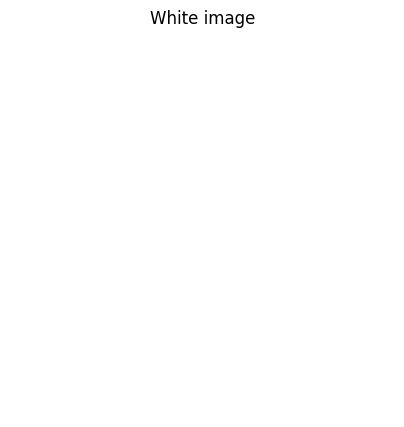

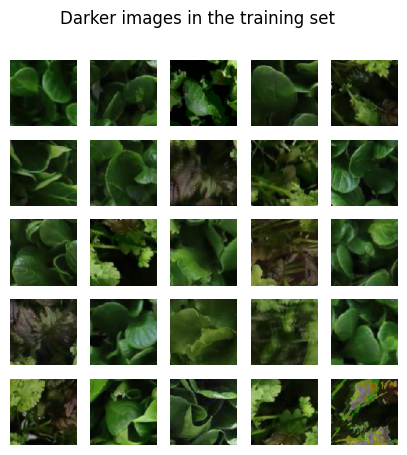

In [ ]:
white_image = np.full((96, 96, 3), 255, dtype=np.uint8)
darker_images_indices = find_most_dissimilar_images(flipped_images_h, brightness_param, white_image)
darker_images = flipped_images_h[darker_images_indices]
darker_labels = flipped_images_h_labels[darker_images_indices]

fig, axes = plt.subplots(figsize=(5, 5))
axes.imshow(white_image)
axes.axis('off')
axes.set_title('White image')

# Plot the most dissimilar images in a 10 by 10 grid
fig, axes = plt.subplots(5, 5, figsize=(5, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(darker_images[i])
    ax.axis('off')

fig.suptitle('Darker images in the training set')  # Add a title to the second plot

plt.show()

In [ ]:
brightened_images = np.empty((darker_images.shape))
for i in range(darker_images.shape[0]):
    brightened_images[i] = tf.image.adjust_brightness(darker_images[i], delta=random.uniform(0.1,0.5))
    brightened_images[i] = np.clip(brightened_images[i], 0, 1)

brightened_labels = darker_labels
print("Brightened images:",brightened_images.shape[0])

Brightened images: 1225


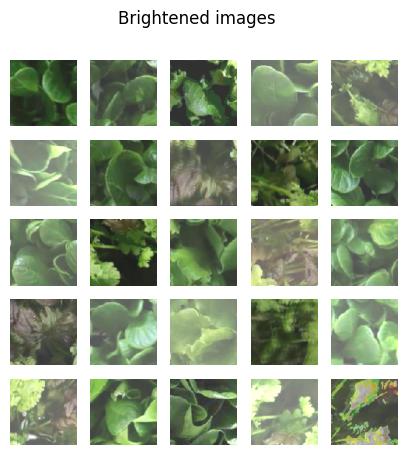

In [ ]:
# Plot the most dissimilar images in a 10 by 10 grid
fig, axes = plt.subplots(5, 5, figsize=(5, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(brightened_images[i])
    ax.axis('off')

fig.suptitle('Brightened images')  # Add a title to the second plot

plt.show()

##### Decrease brightness

Select the darker images in the training set and create a brighter copy of them.

Compare all the images in the training set with a black image to find the most dissimilar images that will also be the brighter ones.

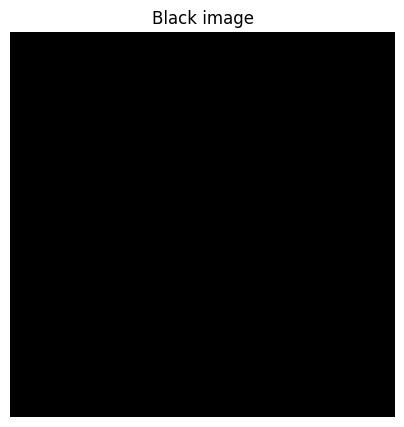

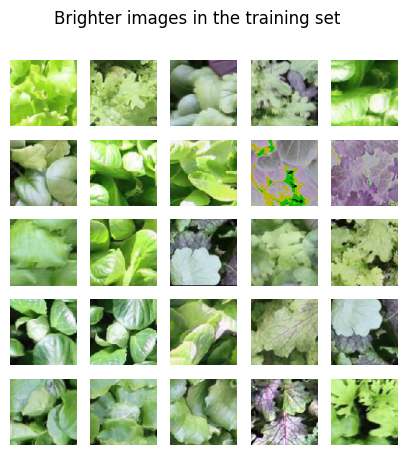

In [ ]:
black_image = np.zeros((96, 96, 3), dtype=np.uint8)
brighter_images_indices = find_most_dissimilar_images(flipped_images_h, brightness_param, black_image)
brighter_images = flipped_images_h[brighter_images_indices]
brighter_labels = flipped_images_h_labels[brighter_images_indices]

fig, axes = plt.subplots(figsize=(5, 5))
axes.imshow(black_image)
axes.axis('off')
axes.set_title('Black image')

# Plot the most dissimilar images in a 10 by 10 grid
fig, axes = plt.subplots(5, 5, figsize=(5, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(brighter_images[i])
    ax.axis('off')

fig.suptitle('Brighter images in the training set')  # Add a title to the second plot

plt.show()

In [ ]:
darkned_images = np.empty((brighter_images.shape))
for i in range(brighter_images.shape[0]):
    darkned_images[i] = tf.image.adjust_brightness(brighter_images[i], delta=random.uniform(-0.1,-0.5))
    darkned_images[i] = np.clip(darkned_images[i], 0, 1)
darkned_labels = brighter_labels

print("Brightened images:",brightened_images.shape[0])

Brightened images: 1225


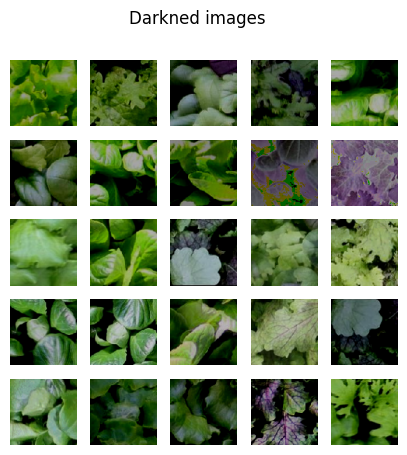

In [ ]:
# Plot the most dissimilar images in a 10 by 10 grid
fig, axes = plt.subplots(5, 5, figsize=(5, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(darkned_images[i])
    ax.axis('off')

fig.suptitle('Darkned images')  # Add a title to the second plot

plt.show()

##### Enlarge Data

In [ ]:
augmented_images = np.concatenate((flipped_images_h, brightened_images,darkned_images))
augmented_labels = np.concatenate((flipped_images_h_labels, brightened_labels,darkned_labels))
training_size = augmented_images.shape[0]
print("Actual train set size:",training_size)

Actual train set size: 7350


In [ ]:
# Find the indices for label 1 and label 0
healty_indices = np.where(augmented_labels == unique_labels[0])[0]
unhealty_indices = np.where(augmented_labels == unique_labels[1])[0]
print("Number of healty images:",healty_indices.shape[0])
print("Number of unhealty images:",unhealty_indices.shape[0])

Number of healty images: 3629
Number of unhealty images: 3721


### Shuffle Data

In [ ]:
def shuffle_array(arr):
    for i in range(len(arr)-1, 0, -1):
        j = random.randint(0, i)
        arr[i], arr[j] = arr[j], arr[i]

In [ ]:
indices_arr = [i for i in range(augmented_images.shape[0])]

In [ ]:
shuffle_array(indices_arr)
print(indices_arr[:15])

[5631, 5435, 3983, 6645, 6318, 3019, 3436, 5025, 4808, 4659, 2542, 2759, 5592, 3254, 6578]


In [ ]:
augmented_images = augmented_images[indices_arr]
augmented_labels = augmented_labels[indices_arr]

In [ ]:
print("The final dimension of the training images is:", augmented_images.shape)
print("The final dimension of the training labels is:", augmented_labels.shape)

The final dimension of the training images is: (7350, 96, 96, 3)
The final dimension of the training labels is: (7350,)


### Evaluate data augmentation

In [ ]:
print("The final dimension of the training images is:", augmented_images.shape)

The final dimension of the training images is: (7350, 96, 96, 3)


In [ ]:
print("The final dimension of the training labels is:", augmented_labels.shape)

The final dimension of the training labels is: (7350,)


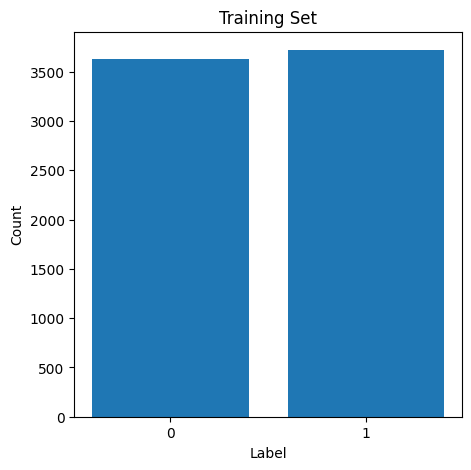

In [ ]:
# Convert y_train to pandas Series
augmix_labels_series = pd.Series(augmented_labels)

# Calculate the count of each label in the training set
label_counts_train = augmix_labels_series.value_counts()

fig, ax = plt.subplots(1, figsize=(5, 5))

# Plot the distribution of labels
ax.bar(label_counts_train.index, label_counts_train.values)
ax.set_xlabel('Label')
ax.set_ylabel('Count')
ax.set_title('Training Set')
ax.set_xticks([0, 1])

plt.show()

In [ ]:
# Find the indices for label 1 and label 0
healty_indices = np.where(augmented_labels == unique_labels[0])[0]
unhealty_indices = np.where(augmented_labels == unique_labels[1])[0]
print("Number of healty images:",healty_indices.shape[0])
print("Number of unhealty images:",unhealty_indices.shape[0])

Number of healty images: 3629
Number of unhealty images: 3721


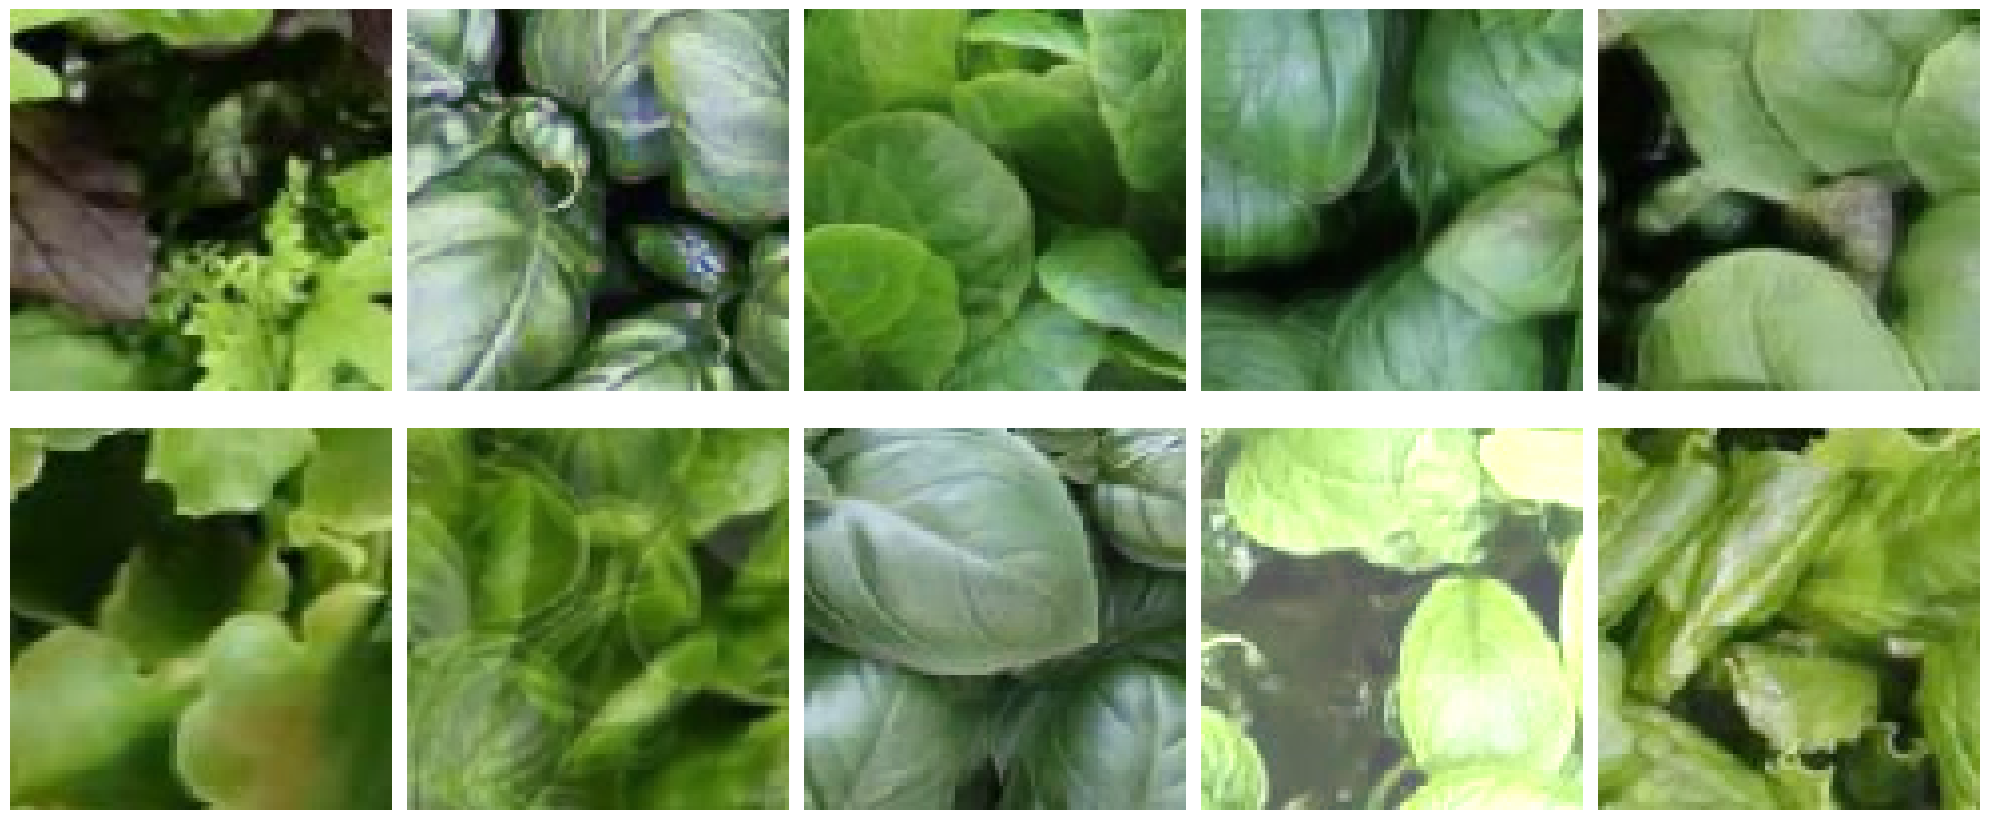

In [ ]:
# Number of images to display
num_img = 10

# Create subplots for displaying items
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(num_img):
    i = i + 40
    ax = axes[i%2, i%num_img//2]
    ax.imshow(augmented_images[indices_arr[i]])
    ax.axis('off')
plt.tight_layout()
plt.show()

### Load augmented data into file

In [ ]:
# Save the arrays into a .npz file
np.savez('AUGMENTED_FINAL.npz', augmented_images=augmented_images, augmented_labels=tfk.utils.to_categorical(augmented_labels,2))